In [1]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression 

%matplotlib inline

# Column names from the word document "Network Anamoly Detection" for the dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dataset = pd.read_csv("../Data/Train.txt", names=column_names)
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### Cleaning and preparing the dataset

In [2]:
# Removing rows with no values in them
print("shape pre-dropna:", dataset.shape)
dataset.dropna(inplace=True)
print("shape post-dropna:", dataset.shape)

shape pre-dropna: (125973, 43)
shape post-dropna: (125973, 43)


In [4]:
# Giving the categories in the nominal features a separate column each with binary/boolean values
temp = pd.get_dummies(dataset[['protocol_type', 'service', 'flag']]).astype('int')
# Replaces three features with eighty-four features boolean
print("Features created from 'protocol_type', 'service', and 'flag':", temp.shape)

# Getting the attack classes from the dataset
attack_classes = dataset.attack
attack_classes_dummy = pd.get_dummies(dataset['attack']).astype('int')

# Normal traffic is classified as 0, while malicious traffic is classed as 1.
def mapping(val):
    if val == "normal":
        return 0
    else:
        return 1
attack_classes_binary = attack_classes.apply(mapping)

# Dropping the independent variable 'attack' and the columns 'protocol_type', 'service', and 'flag' 
temporary_dataset = dataset.drop(['attack', 'protocol_type', 'service', 'flag'], axis=1).astype('float64')

new_dataset = pd.concat([temporary_dataset, temp], axis=1)
print("New dataset's shape:", new_dataset.shape)
new_dataset.head()



Features created from 'protocol_type', 'service', and 'flag': (125973, 84)
New dataset's shape: (125973, 123)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


### Correlation between features

num_compromised and num_root are highly correlated (0.9988334525784719)
num_root and num_compromised are highly correlated (0.9988334525784719)
serror_rate and srv_serror_rate are highly correlated (0.9932892425370415)
serror_rate and dst_host_serror_rate are highly correlated (0.9793730829843228)
serror_rate and dst_host_srv_serror_rate are highly correlated (0.9811389586179857)
serror_rate and flag_S0 are highly correlated (0.9791740914923958)
srv_serror_rate and serror_rate are highly correlated (0.9932892425370415)
srv_serror_rate and dst_host_serror_rate are highly correlated (0.9775960119654394)
srv_serror_rate and dst_host_srv_serror_rate are highly correlated (0.9862517164930875)
srv_serror_rate and flag_S0 are highly correlated (0.9826599622600537)
rerror_rate and srv_rerror_rate are highly correlated (0.9890076529820739)
rerror_rate and dst_host_rerror_rate are highly correlated (0.9267485035759243)
rerror_rate and dst_host_srv_rerror_rate are highly correlated (0.96444866550

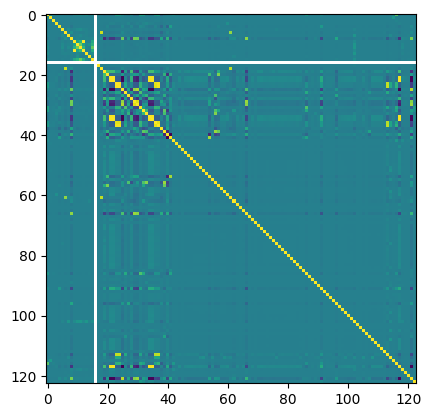

[[1.0, 0.07073682819085414, 0.03487779833437003, -0.0015532805525947443, -0.009865808515815139, 0.003829897181915918, 0.000705120566211187, 0.009528249936349882, -0.06421767647301116, 0.042679474817442095, 0.052790950792928525, 0.08718341292134439, 0.045519157361409816, 0.09911569750163096, -0.0015934673468352128, 0.07041992093460996, nan, -0.00025761943672739616, 0.0004402248819930365, -0.07904231889655419, -0.03947023790265667, -0.06987295957015192, -0.06951028293813129, 0.2006819844142431, 0.19996108167067075, 0.07468058598343401, -0.01373757895926031, -0.04015809532609311, 0.05057003428877992, -0.109775561199984, -0.11600495557790014, 0.2541951745852428, 0.2287373765622746, -0.026669376728929953, -0.06494796244229974, -0.06436051447487312, 0.1738152898998144, 0.19902360421159065, -0.15631061303783145, -0.029263345542364316, -0.004642982519098148, 0.027974374377361635, 0.09319418730832142, 0.0037412564778459014, -0.007744632866980154, -0.0004392939757158932, -0.008205440388428653, -

In [5]:
result = []
for columnx in new_dataset.columns:
    resulting_row = []
    for columny in new_dataset.columns:
        correlation = new_dataset[columnx].corr(new_dataset[columny])
        if (columnx != columny) and ((correlation > 0.9) or (correlation < -0.9)):
            print(f"{columnx} and {columny} are highly correlated ({correlation})")
        resulting_row.append(correlation)
    result.append(resulting_row)

plt.imshow(result)
plt.show()

print(result)

From the results above we can see that the following features are highly correlated:
* num_compromised and num_root
* serror_rate, srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, and flag_S0
* rerror_rate, srv_rerror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate

Therefore the remaining features will be (as the rest will be dropped):
* num_root
* serror_rate
* rerror_rate

In [6]:
# Dropping the features:
# num_compromised,
# srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, flag_S0,
# srv_rerror_rate, dst_host_rerror_rate, and dst_host_srv_rerror_rate 
print("pre:", new_dataset.shape)
features_droppping = ['num_compromised',
                      'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'flag_S0',
                      'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
new_dataset = new_dataset.drop(features_droppping, axis=1).astype('float64')
print("post:", new_dataset.shape)

pre: (125973, 123)


post: (125973, 115)


### Feature importance

Feature: duration coefficient 1.5589741613413026e-06
Feature: src_bytes coefficient 8.858430500267206e-09
Feature: dst_bytes coefficient 7.094954791998057e-09
Feature: land coefficient 2.977115492544097e-08
Feature: wrong_fragment coefficient 6.772229617386761e-06
Feature: urgent coefficient -1.942009342813291e-08
Feature: hot coefficient -1.3269784747597563e-05
Feature: num_failed_logins coefficient -9.511613943917338e-08
Feature: logged_in coefficient -8.492148197613082e-05
Feature: root_shell coefficient -2.572119753231587e-07
Feature: su_attempted coefficient -4.252346694935567e-07
Feature: num_root coefficient -0.0001133872374648421
Feature: num_file_creations coefficient -4.4818679433510745e-06
Feature: num_shells coefficient -7.884370825090021e-08
Feature: num_access_files coefficient -1.188805830127048e-06
Feature: num_outbound_cmds coefficient 0.0
Feature: is_host_login coefficient -3.1015678241578563e-09
Feature: is_guest_login coefficient -1.5548948843430926e-06
Feature: cou

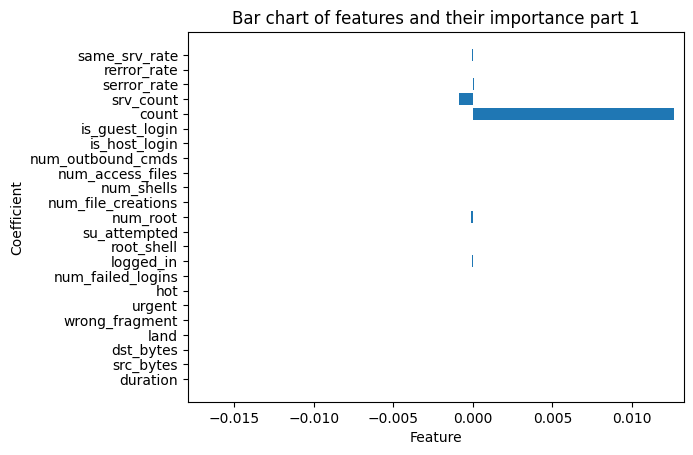

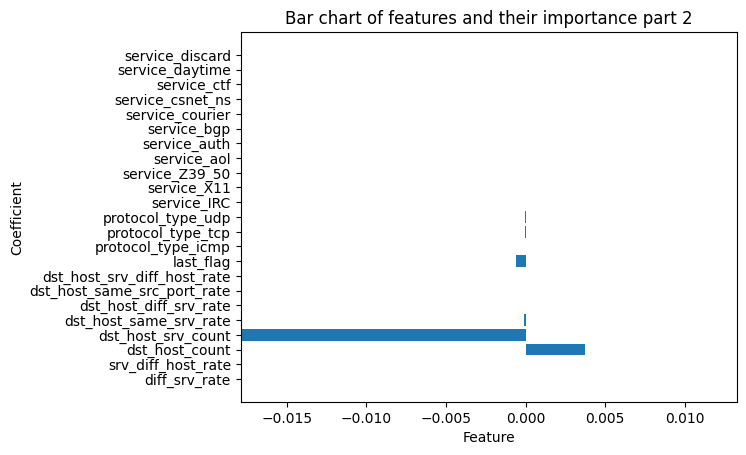

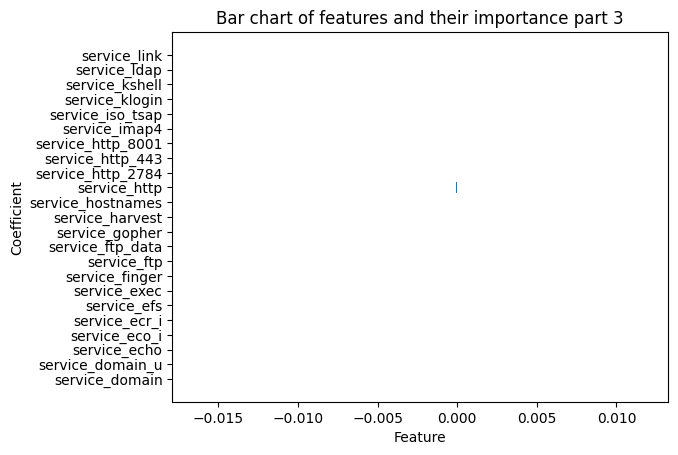

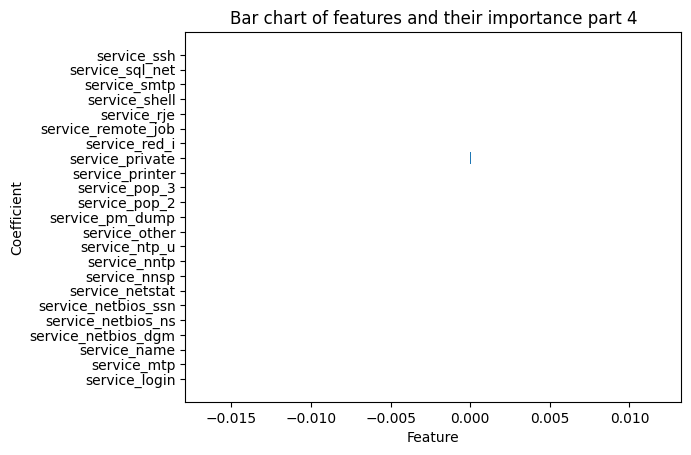

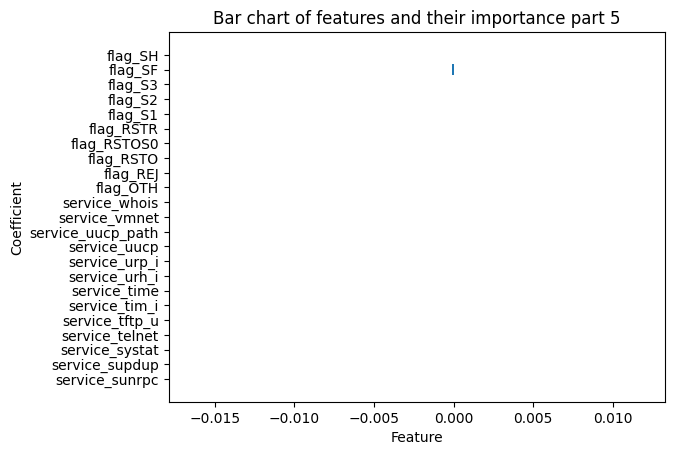

In [7]:
logistical_regression = LogisticRegression(max_iter=250)
logistical_regression.fit(new_dataset, attack_classes_binary)
importance = logistical_regression.coef_[0]

highest_value = max(importance)
lowest_value = min(importance)

for x in range(len(importance)):
    print("Feature:",new_dataset.columns[x], "coefficient", np.float64(importance[x]))
    
splited_importance = np.array_split(importance, 5)
splited_columns = np.array_split(new_dataset.columns, 5)

for index in range(len(splited_importance)):
    plt.barh(splited_columns[index], splited_importance[index], align="center")
    plt.xlabel("Feature")
    plt.ylabel("Coefficient")
    plt.title(f"Bar chart of features and their importance part {index+1}")
    
    plt.xlim(lowest_value - (lowest_value * 0.05), highest_value + (highest_value * 0.05))
    plt.show()

### Forward selection (Finding the features and their best logistical model)

In [11]:
def best_logistical_model_with_the_feature_set_2(dataset, attack_classes, feature_set):
    kfold = KFold(n_splits=10)
    models = []
    scores = []
    
    for train, test in kfold.split(dataset):
        logistical_regression = LogisticRegression(max_iter=2000)
        logistical_regression.fit(dataset.iloc[train][list(feature_set)], attack_classes.iloc[train])

        scores.append(cross_val_score(logistical_regression, dataset.iloc[test][list(feature_set)], attack_classes.iloc[test], scoring='accuracy'))
        models.append(logistical_regression)
    
    highest = 0
    for index, score in enumerate(scores):
        if np.mean(scores[highest]) < np.mean(score):
            highest = index
            
    return {'model': models[highest], 'accuracy': np.mean(scores[highest]), 'std': np.std(scores[highest]),'var':np.var(scores[highest]), 'feature_set': list(feature_set)}

In [12]:
def best_logistical_model_with_the_feature_set(dataset, attack_classes, feature_set):
    kfold = KFold(n_splits=10)
    models = []
    scores = []
    for train, test in kfold.split(dataset):
        logistical_regression = LogisticRegression(max_iter=1500)
        logistical_regression.fit(dataset.iloc[train][list(feature_set)], attack_classes.iloc[train])

        scores.append(cross_val_score(logistical_regression, dataset.iloc[test][list(feature_set)], attack_classes.iloc[test], scoring='accuracy'))
        models.append(logistical_regression)
    
    highest = 0
    for index, score in enumerate(scores):
        if np.mean(scores[highest]) < np.mean(score):
            highest = index
            
    return {'model': models[highest], 'accuracy': np.mean(scores[highest]), 'std': np.std(scores[highest]), 'feature_set': list(feature_set)}

def best_logistical_regression_model_with_a_number_of_predictors_forward_selection(dataset, attack_classes, predictors):
    results = []
    for combination in itertools.combinations(new_dataset.columns, predictors):
        results.append(best_logistical_model_with_the_feature_set(dataset, attack_classes, combination))
    models = pd.DataFrame(results)
    return models

def organize(dataset, attack_class, models):
    accuracy = 0
    features = []
    forward_selected_model = None
    for index, row in models.sort_values(by=['accuracy'], ascending=False).iterrows():
        if index == 0:
            accuracy = row['accuracy']
            features.append(row['feature_set'][0])
        
        model = best_logistical_model_with_the_feature_set(dataset, attack_class, features + row['feature_set'])
        if accuracy < model['accuracy']:
            features.append(row['feature_set'][0])
            forward_selected_model = model
        else:
            return forward_selected_model        

models = best_logistical_regression_model_with_a_number_of_predictors_forward_selection(new_dataset, attack_classes_binary, 1)
models.head()

,model,accuracy,std,feature_set
0,LogisticRegression(max_iter=1500),0.542589,0.002883,[duration]
1,LogisticRegression(max_iter=1500),0.542828,0.000147,[src_bytes]
2,LogisticRegression(max_iter=1500),0.590685,0.096126,[dst_bytes]
3,LogisticRegression(max_iter=1500),0.542828,0.000291,[land]
4,LogisticRegression(max_iter=1500),0.552274,0.002112,[wrong_fragment]


In [ ]:
# def organize_2(dataset, attack_class, models):
#     accuracy = 0
#     features = []
#     model = None
#     for index, row in enumerate(models.sort_values(by=['accuracy'], ascending=False).iterrows()):
#         if index == 0:
#             accuracy = row['accuracy']
#             features.append(row['feature_set'][0])
        
#         model = best_logistical_model_with_the_feature_set(dataset, attack_class, features + list(row['feature_set']))
#         if accuracy < model['accuracy']:
#             features.append(row['feature_set'][0])
#         else:
#             return features 
        
        
accuracy = 0
features = []
best_model = None
for index, row in models.sort_values(by=['accuracy'], ascending=False).iterrows():
    if index == 0:
        accuracy = row['accuracy']
        features.append(row['feature_set'][0])
        
    print("------")
    print(f"{index + 1}/{len(new_dataset.columns)}")
    model = best_logistical_model_with_the_feature_set_2(new_dataset, attack_classes_binary, features + row['feature_set'])
    if accuracy < model['accuracy']:
        features.append(row['feature_set'][0])
        best_model = model
        
        print("Features:", model['feature_set'])
        print("Old-accuracy:", accuracy)
        print("New-accuracy:", model['accuracy'])
        accuracy = model['accuracy']


------
Features: ['flag_SF']
Old-accuracy: 0
New-accuracy: 0.8802892619268163
------
Features: ['flag_SF', 'dst_host_srv_count']
Old-accuracy: 0.8802892619268163
New-accuracy: 0.8854481496184553
------
Features: ['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate']
Old-accuracy: 0.8854481496184553
New-accuracy: 0.8979122478685797
------
Features: ['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'count']
Old-accuracy: 0.8979122478685797
New-accuracy: 0.9126784060190174
------
Features: ['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'count', 'serror_rate']
Old-accuracy: 0.9126784060190174
New-accuracy: 0.9145823172460726
------
Features: ['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'count', 'serror_rate', 'service_http']
Old-accuracy: 0.9145823172460726
New-accuracy: 0.9215692483159732
------
Features: ['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'count', 'serror_rate', 'service_http', 'last_flag']
Old-accuracy: 0.92156924831597

KeyboardInterrupt: 

In [ ]:
print("Model summary:\n")
print(best_model['model'].summary())
print("Accuracy:", best_model['accuracy'])
print("Standard deviation:", best_model['std'])
print("Features:", best_model['feature_set'])

#for now (stored some of the features that increased the accuracy of the model)
#['flag_SF', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'count', 'serror_rate', 'service_http', 'last_flag', 'service_private', 'dst_host_count', 'rerror_rate', 'protocol_type_icmp', 'diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate' ,'service_uucp', 'service_whois']
# 0.8802892619268163
# 0.8854481496184553
# 0.8979122478685797
# 0.9126784060190174
# 0.9145823172460726
# 0.9215692483159732
# 0.9564976023491306
# 0.9597523267610605
# 0.9616573092118944
# 0.9617366427846777
# 0.9783281977605123
# 0.979122195126562
# 0.979995305519323
# 0.9800745130657793
# 0.980233306237673
# 0.9804714644889316

Think i did forward selection wrong. re-doing it

In [13]:
features = []
accuracies = []
features.append(models.loc[models['accuracy'].idxmax()]['feature_set'])
features_temp = models.loc[models['accuracy'].idxmax()]['feature_set'] 

accuracy = models.loc[models['accuracy'].idxmax()]['accuracy']
accuracies.append(accuracy)
best_model = models.loc[models['accuracy'].idxmax()]

run = True
iteration = 0
while run:
    temp_list_results = []
    for feature in list(filter(lambda x: x not in features_temp, new_dataset.columns)):
        model = best_logistical_model_with_the_feature_set_2(new_dataset, attack_classes_binary, [feature] + features_temp)
        temp_list_results.append(model)
        
    temp_list_models = pd.DataFrame(temp_list_results)
    
    largest_index = temp_list_models['accuracy'].idxmax()
    # print(largest_index)
    # print(temp_list_models.loc[largest_index])
    accuracies.append(temp_list_models.loc[largest_index]['accuracy'])
    
    
    if ((temp_list_models.loc[largest_index]['accuracy'] - accuracy) > 0.01):    
        print(f"--- iteration {iteration} ---")
        print("Features:", features_temp)
        print("Old-accuracy:", accuracy)
        print("New-accuracy:", temp_list_models.loc[largest_index]['accuracy'])
        
        features.append(temp_list_models.loc[largest_index]['feature_set'])
        features_temp = temp_list_models.loc[largest_index]['feature_set']
        
        accuracy = temp_list_models.loc[largest_index]['accuracy']
        best_model = temp_list_models.loc[largest_index]
    else:
        run = False
    iteration += 1
    
print("Best forward selected logistical regression model features, accuracy and standard deviation")
print("Features:", best_model['feature_set'])
print("Accuracy:", best_model['accuracy'])
print("Standard deviation:", best_model['std'])

print("acurracies:", accuracies)




# model                          LogisticRegression(max_iter=2000)
# accuracy                                                0.958244
# std                                                     0.005038
# feature_set    [service_http, service_ecr_i, last_flag, flag_SF]

# confusion matrix
# plot showing the accuracy over different number of predictors,
# and a graph showing the logistical regression using a training set to make the model and test to show as the datapoints
# acurracies: [0.9263316571831857, 0.944828289129599, 0.9582437601214894, 0.9648330781300214]

--- iteration 0 ---
Features: ['flag_SF']
Old-accuracy: 0.8802892619268163
New-accuracy: 0.9263316571831857
--- iteration 1 ---
Features: ['last_flag', 'flag_SF']
Old-accuracy: 0.9263316571831857
New-accuracy: 0.944828289129599
--- iteration 2 ---
Features: ['service_ecr_i', 'last_flag', 'flag_SF']
Old-accuracy: 0.944828289129599
New-accuracy: 0.9582437601214894
Best forward selected logistical regression model features, accuracy and standard deviation
Features: ['service_http', 'service_ecr_i', 'last_flag', 'flag_SF']
Accuracy: 0.9582437601214894
Standard deviation: 0.0050382333241812405
acurracies: [0.8802892619268163, 0.9263316571831857, 0.944828289129599, 0.9582437601214894, 0.9648330781300214]


### Finding the best model and its feature set

In [ ]:
# Function for finding the best model
def best_logistical_regression_model_with_a_features_set(dataset, attack_classes, feature_set):
    logistical_regression = LogisticRegression()
    logistical_regression.fit(new_dataset[list(feature_set)], attack_classes_binary)
    kfold = KFold(n_splits=10, shuffle=True)
    score = cross_val_score(logistical_regression, new_dataset[list(feature_set)], attack_classes_binary, scoring='accuracy', cv=kfold)
    
    return {'model': logistical_regression, 'accuracy': np.mean(score), 'std': np.std(score), 'feature_set': feature_set} #loocv(dataset, feature_set, attack_classes, logistical_regression) # ask what type of way your deteming it? something about forward  analysis

def test(dataset, attack_classes, feature_set):
    
    kfold = KFold(n_splits=10)
    models = []
    scores = []
    for train, test in kfold.split(dataset):
        logistical_regression = LogisticRegression()
        logistical_regression.fit(train[list(feature_set)], attack_classes)
        
        scores.append(cross_val_score(logistical_regression, test[list(feature_set)], attack_classes, scoring='accuracy'))
        models.append(logistical_regression)
    
    highest = 0
    index = 0
    for score in scores:
        if scores[highest] < np.mean(score):
            highest = index
        index += 1
            
    return {'model': models[highest], 'accuracy': np.mean(scores[highest]), 'std': np.std(score[highest]), 'feature_set': feature_set} #loocv(dataset, feature_set, attack_classes, logistical_regression) # ask what type of way your deteming it? something about forward  analysis
    

def best_logistical_regression_model_with_a_number_of_predictors(dataset, attack_classes, predictors):
    results = []
    for combination in itertools.combinations(dataset.columns, predictors):
        results.append(best_logistical_regression_model_with_a_features_set(dataset, attack_classes, combination))
    models = pd.DataFrame(results)
    
    # print(models['accuracy'])
    return models.loc[models['accuracy'].argmax()]

def get_best_logistical_regression_model(dataset, attack_classes):
    results = []
    for predictors in range(1, len(dataset.columns)):
        results.append(best_logistical_regression_model_with_a_number_of_predictors(dataset, attack_classes, predictors))
    best_models = pd.DataFrame(results)
    
    return best_models
    
    # indexes = np.asarray(best_models.keys())
    # print(best_models.head())
    # plt.plot(best_models.apply(lambda row: row[1].rsquared, axis=1))
    # plt.title("Plot of the r squared value over the best models")
    # plt.show()
    
    # plt.plot(best_models.apply(lambda row: row[1].bic, axis=1))
    # plt.title("Plot of the bic value over the best models")
    # plt.show()
    
    # plt.plot(best_models.apply(lambda row: row[1].aic, axis=1))
    # plt.title("Plot of the aic value over the best models")
    # plt.show()
    
    # plt.plot(best_models.apply(lambda row: row[1].rsquared_adj, axis=1))
    # plt.title("Plot of the adjusted r squared value over the best models")
    # plt.show()

### Finding the best model

In [ ]:
# best_logistical_regression_model_with_a_number_of_predictors(new_dataset, attack_classes_binary, 1)['model']

In [ ]:
# models = get_best_logistical_regression_model(new_dataset, attack_classes_binary)

In [ ]:
print(best_logistical_regression_model_with_a_features_set(new_dataset, attack_classes_binary, ['wrong_fragment', 'count']))
print(test(new_dataset, attack_classes_binary, ['wrong_fragment', 'count']))


{'model': LogisticRegression(), 'accuracy': 0.8215490360290729, 'std': 0.0033811454067401467, 'feature_set': ['wrong_fragment', 'count']}


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[0.8802892619268163, 0.9263316571831857, 0.944828289129599, 0.9582437601214894, 0.9648330781300214]


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (6).

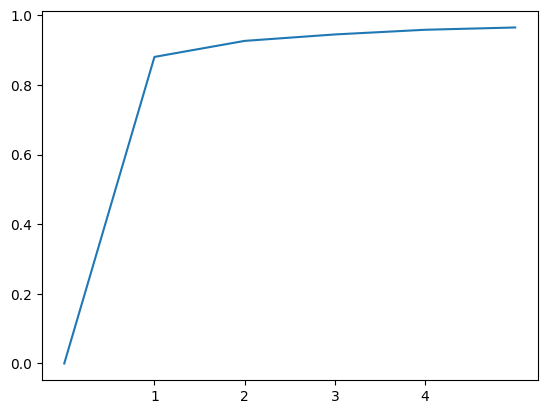

In [14]:
print(accuracies)
plt.plot(range(len(accuracies)+1), [0] + accuracies)
plt.xticks(ticks=[1,2,3,4], labels=['', 'flag_SF', '& last_flag', '& service_ecr_i', '& service_http', ''], rotation="vertical")
plt.show()

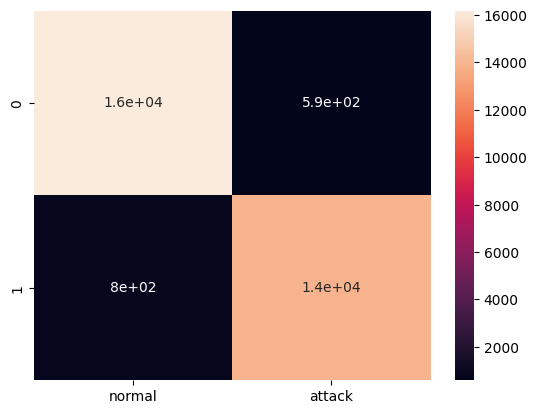

In [16]:
# best_model = best_logistical_model_with_the_feature_set_2(new_dataset, attack_classes_binary, ['service_http', 'service_ecr_i', 'last_flag', 'flag_SF'])
dataset_train, dataset_test, attack_classes_binary_train, attack_classes_binary_test = train_test_split(new_dataset, attack_classes_binary)
matrix = confusion_matrix(attack_classes_binary_test, best_model['model'].predict(dataset_test[best_model['feature_set']]))
# sns.set(font_scale=1.2)
sns.heatmap(pd.DataFrame(matrix, columns=["normal", "attack"]), annot=True)
plt.show()


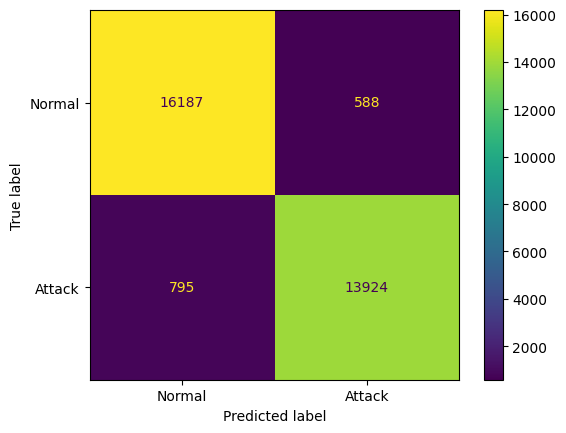

In [17]:
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Normal', "Attack"])
display.plot()
plt.show()

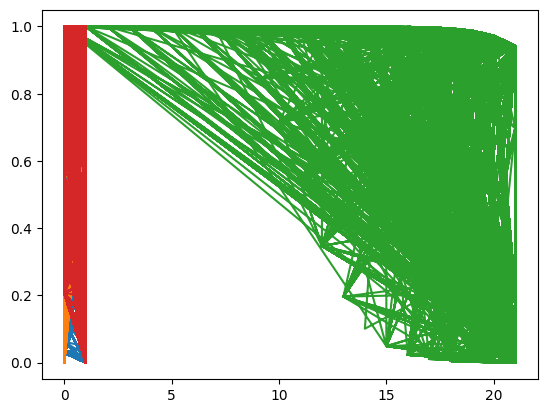

In [18]:
# sns.regplot(x=dataset_test, y=attack_classes_binary_test, data=new_dataset, logistic=True, ci=None)
# plt.show()

plt.plot(dataset_test[best_model['feature_set']], best_model['model'].predict_proba(dataset_test[best_model['feature_set']])[:, 1])
plt.show()

In [19]:
print("Stored accuracy:", best_model['accuracy'])
correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(attack_classes_binary_test) - correct_predictions)
print("Total samples:", len(attack_classes_binary_test))
print("Accuracy score:", correct_predictions/len(attack_classes_binary_test))

print("Stored Standard deviation:", best_model['std'])
print("Stored variance:", best_model['var'])

Stored accuracy: 0.9582437601214894
Correct predictions: 30111
Incorrect predictions: 1383
Total samples: 31494
Accuracy score: 0.9560868736902267
Stored Standard deviation: 0.0050382333241812405
Stored variance: 2.5383795028890355e-05
